<a href="https://colab.research.google.com/github/HknyYtbz/cng-562/blob/master/YATBAZ_aerial_cactus_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [0]:
import numpy as np
import pandas as pd

Please upload your Kaggle API JSON named as kaggle.json to download the data


In [0]:
from google.colab import files
#Kaggle api key upload
files.upload()
#Essential downloads for the project, especially the kaggle dataset download
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json 
!kaggle competitions download -c aerial-cactus-identification
!ls


Saving kaggle.json to kaggle.json
  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 45.7MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 50.0MB/s]
100% 4.20M/4.20M [00:00<00:00, 27.1MB/s]

 88% 17.0M/19.2M [00:00<00:00, 30.5MB/s]
100% 19.2M/19.2M [00:00<00:00, 55.2MB/s]
kaggle.json  sample_data  sample_submission.csv  test.zip  train.csv  train.zip


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/train.zip", 'r')
!mkdir cactus
zip_ref.extractall("/content/cactus")
zip_ref.close()

#Preprocessing

##Image  to Tensor Conversion & Train-Test Split


In [0]:
import torch
import numpy as np
from PIL import Image
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = None
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = "cuda"

CUDA is available!  Training on GPU ...


In [0]:
data = pd.read_csv("train.csv")
data.head()
pth = "/content/cactus/train/"

In [0]:
data.values

array([['0004be2cfeaba1c0361d39e2b000257b.jpg', 1],
       ['000c8a36845c0208e833c79c1bffedd1.jpg', 1],
       ['000d1e9a533f62e55c289303b072733d.jpg', 1],
       ...,
       ['fff059ecc91b30be5745e8b81111dc7b.jpg', 1],
       ['fff43acb3b7a23edcc4ae937be2b7522.jpg', 0],
       ['fffd9e9b990eba07c836745d8aef1a3a.jpg', 1]], dtype=object)

In [0]:
from torchvision import transforms 

def train_tf(x):
    im_aug = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
    x = im_aug(x)
    return x

In [0]:
import os
import cv2
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import time
from torch.autograd import Variable
from PIL import Image

train_img = []
train_label = []
for i in data.values:
    img = cv2.imread(pth+i[0])
    tf_img = Image.fromarray(img.astype('uint8')).convert('RGB')
    tf_img1 = train_tf(tf_img)
    train_img.append((tf_img1, i[1]))

import random
test_data = random.sample(train_img, int(0.2 * len(train_img)))
train_data = list(set(train_img).difference(set(test_data)))
val_data = random.sample(train_img, int(0.1 * len(train_img)))
train_data = list(set(train_img).difference(set(val_data)))

print("")
print(len(train_data),len(test_data),len(val_data))


15750 3500 1750


In [0]:
type(train_data[0][0])

torch.Tensor

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 

# specify the image classes
classes = ["No Cactus",'Cactus']

##Data Visualization

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

1.0
0.8627451
1.0
0.7921569
1.0
1.0
1.0
0.99215686
0.81960785
0.78431374


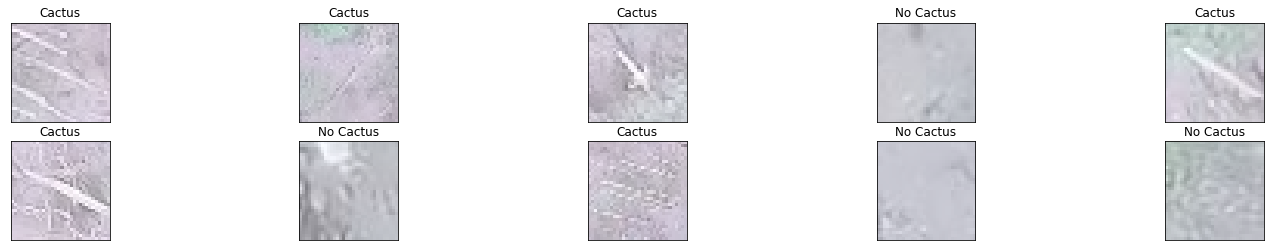

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

#CNN Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 360x360x3 image tensor)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
       
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 12 * 12 -> 4096)
        self.fc1 = nn.Linear(32*4*4, 512)
        
        # linear layer (500 -> 10)
        
        
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        # flatten image input
        x = x.view(-1, 32 * 4 * 4)
        #print(x.shape)
        # add dropout layer
        # add 1st hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        # add dropout layer
        # add 2nd hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc2(x)))  
        x = self.dropout(self.fc3(x)) 
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.25)
)


##Training

In [0]:
n_epochs = 30
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), "/content/cactus_model.pt")
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.581458 	Validation Loss: 0.547148
Validation loss decreased (inf --> 0.547148).  Saving model ...
Epoch: 2 	Training Loss: 0.565927 	Validation Loss: 0.528009
Validation loss decreased (0.547148 --> 0.528009).  Saving model ...
Epoch: 3 	Training Loss: 0.489491 	Validation Loss: 0.335104
Validation loss decreased (0.528009 --> 0.335104).  Saving model ...
Epoch: 4 	Training Loss: 0.342451 	Validation Loss: 0.208256
Validation loss decreased (0.335104 --> 0.208256).  Saving model ...
Epoch: 5 	Training Loss: 0.268228 	Validation Loss: 0.172823
Validation loss decreased (0.208256 --> 0.172823).  Saving model ...
Epoch: 6 	Training Loss: 0.236076 	Validation Loss: 0.143319
Validation loss decreased (0.172823 --> 0.143319).  Saving model ...
Epoch: 7 	Training Loss: 0.217163 	Validation Loss: 0.139783
Validation loss decreased (0.143319 --> 0.139783).  Saving model ...
Epoch: 8 	Training Loss: 0.204470 	Validation Loss: 0.121122
Validation loss decreased (0.13978

##Testing

In [0]:
model.load_state_dict(torch.load("/content/cactus_model.pt"))
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    ct = 0
    for i in range(len(list(target.data))   ):
        try:
            label = target.data[i]
            #print(correct)
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except IndexError:
            ct+=1
            continue
#print("Problematic Count: %d"%ct)
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.050251

Test Accuracy of No Cactus: 95% (842/885)
Test Accuracy of Cactus: 99% (2594/2615)

Test Accuracy (Overall): 98% (3436/3500)


#Transfer Learning

##DenseNet

In [0]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
model2 =models.densenet121(pretrained=True)
#print(model2)

In [0]:
for param in model2.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(
        OrderedDict([   ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ])
    )
model2.classifier = classifier
#print(model2)


In [0]:
optimizer = optim.Adam(model2.classifier.parameters(), lr=0.003)
criterion = nn.NLLLoss()
#model2.to(device)

###Training

In [0]:
n_epochs = 30
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model2.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model2.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model2.state_dict(), "/content/cactus_modelDense.pt")
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.288653 	Validation Loss: 0.315957
Validation loss decreased (inf --> 0.315957).  Saving model ...
Epoch: 2 	Training Loss: 0.212256 	Validation Loss: 0.420261
Epoch: 3 	Training Loss: 0.173405 	Validation Loss: 0.443511
Epoch: 4 	Training Loss: 0.139085 	Validation Loss: 0.553977
Epoch: 5 	Training Loss: 0.106227 	Validation Loss: 0.577670
Epoch: 6 	Training Loss: 0.089293 	Validation Loss: 0.622139
Epoch: 7 	Training Loss: 0.080199 	Validation Loss: 1.111834
Epoch: 8 	Training Loss: 0.076077 	Validation Loss: 0.645682
Epoch: 9 	Training Loss: 0.071176 	Validation Loss: 1.130723
Epoch: 10 	Training Loss: 0.065080 	Validation Loss: 1.545496
Epoch: 11 	Training Loss: 0.051402 	Validation Loss: 1.374199
Epoch: 12 	Training Loss: 0.049382 	Validation Loss: 1.185562
Epoch: 13 	Training Loss: 0.039709 	Validation Loss: 1.292913
Epoch: 14 	Training Loss: 0.031089 	Validation Loss: 1.094481
Epoch: 15 	Training Loss: 0.031170 	Validation Loss: 1.531394
Epoch: 16 	Trai

###Testing

In [0]:
model2.load_state_dict(torch.load("/content/cactus_modelDense.pt"))
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model2.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model2(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    ct = 0
    for i in range(len(list(target.data))   ):
        try:
            label = target.data[i]
            #print(correct)
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except IndexError:
            ct+=1
            continue
#print("Problematic Count: %d"%ct)
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.322314

Test Accuracy of No Cactus: 80% (715/885)
Test Accuracy of Cactus: 97% (2544/2615)

Test Accuracy (Overall): 93% (3259/3500)


##ResNet50

In [0]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
model3 =models.resnet50(pretrained=True)
print(model3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 81785945.87it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                                 ("fc",nn.Linear(2048, 1000)),
                                 ("relu",nn.ReLU()),
                                 ("dropout",nn.Dropout(0.2)),
                                 ("a1",nn.Linear(1000, 512)),
                                 ("relu",nn.ReLU()),
                                 ("dropout",nn.Dropout(0.2)),
                                 ("a2",nn.Linear(512, 256)),
                                 ("relu2",nn.ReLU()),
                                 ("dropout2",nn.Dropout(0.2)),
                                 ("a3",nn.Linear(256, 2)),
                                ("output", nn.LogSoftmax(dim=1))]))
model3.fc = classifier
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model3.fc.parameters(), lr=0.003)

model3.to(device);
print(model3)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

###Training

In [0]:
n_epochs = 30
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model3.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model3(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model3.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model3(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model3.state_dict(), "/content/cactus_modelResNet50.pt")
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.404669 	Validation Loss: 0.993865
Validation loss decreased (inf --> 0.993865).  Saving model ...
Epoch: 2 	Training Loss: 0.325676 	Validation Loss: 0.585328
Validation loss decreased (0.993865 --> 0.585328).  Saving model ...
Epoch: 3 	Training Loss: 0.326939 	Validation Loss: 0.341785
Validation loss decreased (0.585328 --> 0.341785).  Saving model ...
Epoch: 4 	Training Loss: 0.324269 	Validation Loss: 0.956106
Epoch: 5 	Training Loss: 0.302684 	Validation Loss: 0.403404
Epoch: 6 	Training Loss: 0.307074 	Validation Loss: 1.547060
Epoch: 7 	Training Loss: 0.290946 	Validation Loss: 0.239570
Validation loss decreased (0.341785 --> 0.239570).  Saving model ...
Epoch: 8 	Training Loss: 0.307798 	Validation Loss: 0.507115
Epoch: 9 	Training Loss: 0.277728 	Validation Loss: 0.947925
Epoch: 10 	Training Loss: 0.286134 	Validation Loss: 2.052384
Epoch: 11 	Training Loss: 0.295858 	Validation Loss: 0.258821
Epoch: 12 	Training Loss: 0.284777 	Validation Loss: 0.2

###Testing

In [0]:
model3.load_state_dict(torch.load("/content/cactus_modelResNet50.pt"))
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model3.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model3(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    ct = 0
    for i in range(len(list(target.data))   ):
        try:
            label = target.data[i]
            #print(correct)
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except IndexError:
            ct+=1
            continue
#print("Problematic Count: %d"%ct)
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.257843

Test Accuracy of No Cactus: 67% (595/885)
Test Accuracy of Cactus: 95% (2507/2615)

Test Accuracy (Overall): 88% (3102/3500)


#Conclusion

In this dataset, we had many images (32x32) labeled as cactus or not cactus . I simply load the data using PyTorch (with their respective label) and generated a train and test sample ( In the process I coverted images to sensors and appied some transformations to make the model more robust). Apart from that no processing done on the data.

I used my own CNN network with 3 convolutional layer and 3 fully connected layer. Convolutional layers have 32 3x3 kernels and max pooling layer between them.  For training I have also generated a validation set from the training set to avoid overfitting and saved the model when the validation loss is decreased. The accuracy obtained is  98%.

Having tried the model I implemented, I have also tried pretrained DenseNet and ResNet by modifying their fully connected layers and obtained  93% and 88% respectively.
 
As a future work, other pretrained models can be used or different CNN architectures can be applied.

All in all, in this dataset, I had a chance to explore CNN and well-known architectures better and learned how to load different type of image datasets.